In [1]:
import os
import tensorflow as tf #tf 2.0.0
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [3]:
dataset_dir = os.path.join(r'D:\IIT\Subjects\(4605)IRP\Devlo\Augmented_DataSet_Split')

Batch_size = 32
img_h = 128
img_w = 128
num_classes=4
classes = ['healthy', 'live_wood', 'pink_wax', 'stem_canker']

In [4]:
# Training
SEED = 1234
tf.random.set_seed(SEED) 

training_dir = os.path.join(dataset_dir, 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(128, 128),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_dir = os.path.join(dataset_dir, 'val')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(128, 128),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)
# Test
test_dir = os.path.join(dataset_dir, 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(128, 128),
                                             batch_size=32, 
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )


Found 6698 images belonging to 4 classes.
Found 1914 images belonging to 4 classes.
Found 958 images belonging to 4 classes.


Visualization data

In [5]:
CLASS_NAMES = np.array(['healthy', 'live_wood', 'pink_wax', 'stem_canker'])

ResNet152V2 Model

In [6]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply

def squeeze_excite_block(input_tensor, ratio=16):
    """
    Squeeze-and-Excitation (SE) block implementation.
    It recalibrates feature maps based on global average pooling.
    """
    channels = input_tensor.shape[-1]
    squeeze = GlobalAveragePooling2D()(input_tensor)
    excitation = Dense(channels // ratio, activation='relu', use_bias=False)(squeeze)
    excitation = Dense(channels, activation='sigmoid', use_bias=False)(excitation)
    excitation = Reshape((1, 1, channels))(excitation)
    return Multiply()([input_tensor, excitation])

In [8]:

from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D

# The last 15 layers fine-tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output

# Apply the SE attention block
x = squeeze_excite_block(x)  # Adding attention mechanism

x = GlobalAveragePooling2D()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(units=4, activation='softmax')(x)

model = Model(ResNet_model.input, output)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 34, 34,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_0_c

 Total params: 60,169,732 (229.53 MB)

 Trainable params: 7,357,444 (28.07 MB)

 Non-trainable params: 52,812,288 (201.46 MB)

In [9]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when validation accuracy stops improving
lrr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.4, 
    min_lr=0.0001
)

callbacks = [lrr]

# Using len() to get steps per epoch
STEP_SIZE_TRAIN = len(train_gen)  
STEP_SIZE_VALID = len(valid_gen)

# Use fit() instead of fit_generator()
transfer_learning_history = model.fit(
    train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=30,
    callbacks=callbacks
)


c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5833 - loss: 0.9683

c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


210/210 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.5836 - loss: 0.9678 - val_accuracy: 0.6311 - val_loss: 0.9157 - learning_rate: 0.0010
Epoch 2/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.7133 - loss: 0.7437 - val_accuracy: 0.7158 - val_loss: 0.7169 - learning_rate: 0.0010
Epoch 3/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.7154 - loss: 0.7088 - val_accuracy: 0.7142 - val_loss: 0.7215 - learning_rate: 0.0010
Epoch 4/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.7177 - loss: 0.7043 - val_accuracy: 0.7184 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 5/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.7308 - loss: 0.6723 - val_accuracy: 0.7236 - val_loss: 0.6861 - learning_rate: 0.0010
Epoch 6/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.7344 - loss: 0.6479 - val_accuracy: 0.7252 - val_loss: 0.7424 - learning_rate: 0.0010
Epoch 7/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.7479 - loss: 0.6388 - val_

Visualization accuracy and loss

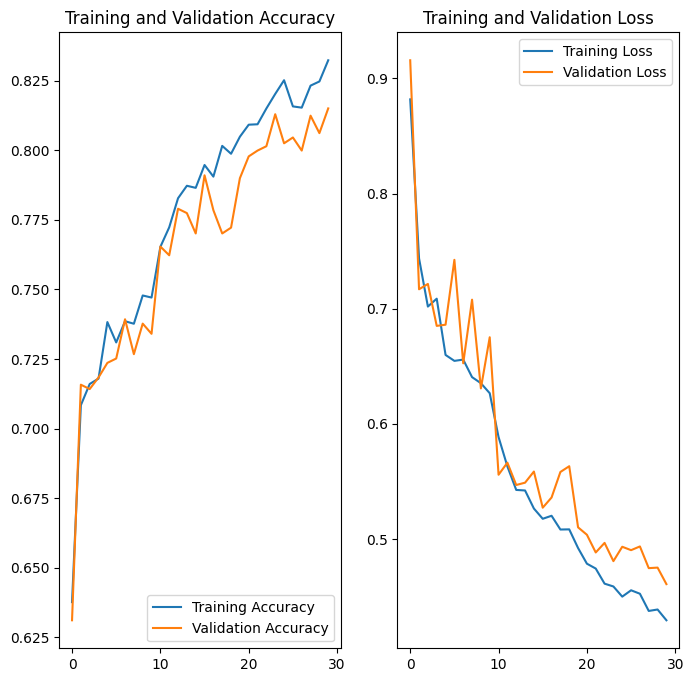

In [11]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model evaluate with validation set

In [12]:
model.evaluate(valid_gen, steps=STEP_SIZE_VALID,verbose=1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8155 - loss: 0.4697


[0.4868302345275879, 0.8040752410888672]